# Online Retail DataSet

##### The Online Retail dataset is a collection of transactional data from an online retail company. The dataset contains information about customer purchases between 01/12/2010 and 09/12/2011. 

The company specializes in selling unique gifts and has a large number of wholesale customers. 

The analysis of this dataset involves several steps, including data reading and understanding, data cleaning, data preparation for modeling, actual modeling, and final analysis and documentation of the results.

In order to perform targeted marketing, it is common to cluster the data from an online store into specific groups. 
###### One common approach is to use RFM Analysis, which stands for Recency, Frequency, and Monetary Value. This analysis allows us to transform the dataset from being organized by individual orders to being organized by individual customers. 
By analyzing customers based on their recency of purchases, frequency of purchases, and monetary value of purchases, we can segment them into different groups for more effective targeted marketing strategies.

##### The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis

## Step-1 Importing Libraries, Warnings and Datasets

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
# read the dataset
retail_df = pd.read_csv("D:\\iiitb\\Course 4 ML Part 1\\Unsupervised Learning  Clustering\\Online+Retail.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [8]:
# basics of the df
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Step-2 Cleaning The Data

In [9]:
# missing values
round(100*(retail_df.isnull().sum())/len(retail_df), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [10]:
# drop all rows having missing values
retail_df = retail_df.dropna()
retail_df.shape

(406829, 8)

In [11]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [12]:
# new column: amount 
retail_df['amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


## Step-3 Data Preperation

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

##### 3.1 Group by M 

In [14]:
grouped_df = retail_df.groupby('CustomerID')['amount'].sum()
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


##### 3.2 Group by F

In [15]:
frequency = retail_df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'frequency']
frequency.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


##### 3.3 Merge the Two DataFrames

In [16]:
grouped_df = pd.merge(grouped_df, frequency, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [17]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


##### 3.4 Group By R

In [18]:
# convert to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [19]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [20]:
# compute the max date
max_date = max(retail_df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [21]:
# compute the diff
retail_df['diff'] = max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [22]:
# recency
last_purchase = retail_df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [23]:
# merge
grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [24]:
# number of days only
grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


##### 3.5 outlier treatment

{'whiskers': [<matplotlib.lines.Line2D at 0x1dd0836f340>,
 'caps': [<matplotlib.lines.Line2D at 0x1dd0836f8e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dd08333eb0>],
 'medians': [<matplotlib.lines.Line2D at 0x1dd0836fe80>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dd08351190>],
 'means': []}

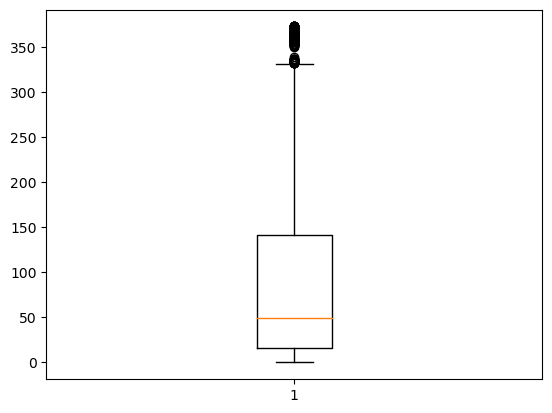

In [25]:
plt.boxplot(grouped_df['recency'])

##### two types of outliers:
- statistical
- domain specific

In [27]:
# removing (statistical) outliers
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]


##### 3.6 rescaling

In [28]:
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [29]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


##### 3.7 Hopkins Test

##### Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [41]:
 def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

3.7.1 First convert the numpy array that you have to a dataframe

In [42]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']

3.7.2 Use the Hopkins Statistic function by passing the above dataframe as a paramter

In [43]:
hopkins(rfm_df_scaled)

0.954743862226349

SInce Value of Hookins Test is close to 1 it means there may exsists valueabl

## Step-4: Modelling

In [32]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [33]:
kmeans.labels_

array([2, 3, 0, ..., 2, 0, 0])

4.1 Finding the Optimal Number of Clusters (Using SSD)

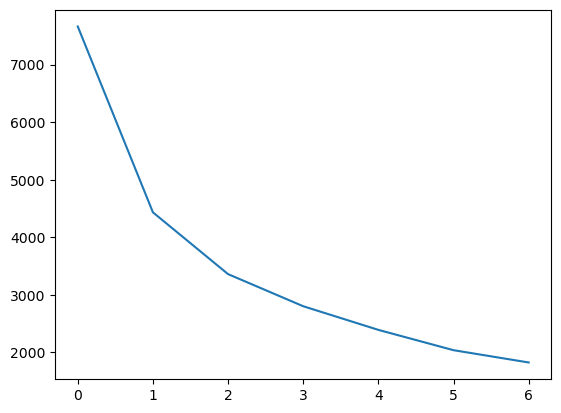

In [34]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [35]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.4816217519322445
For n_clusters=5, the silhouette score is 0.4646444032280179
For n_clusters=6, the silhouette score is 0.41707885139850487
For n_clusters=7, the silhouette score is 0.41768907282021733
For n_clusters=8, the silhouette score is 0.4093799889419855


In [36]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [37]:
kmeans.labels_

array([2, 0, 1, ..., 2, 1, 1])

In [38]:
# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,2


<AxesSubplot:xlabel='cluster_id', ylabel='amount'>

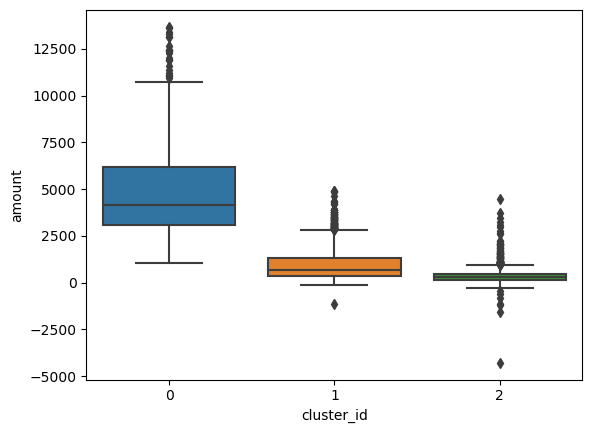

In [39]:
# plot
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)

<AxesSubplot:xlabel='cluster_id', ylabel='recency'>

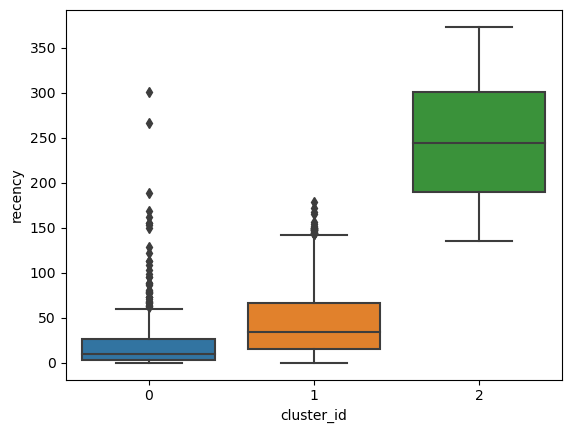

In [44]:
# plot
sns.boxplot(x='cluster_id', y='recency', data=grouped_df)

<AxesSubplot:xlabel='cluster_id', ylabel='frequency'>

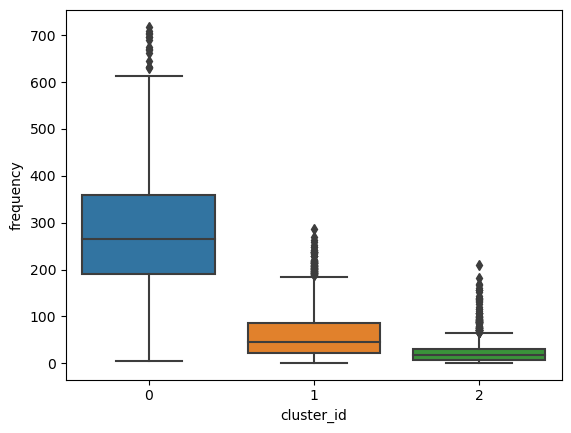

In [45]:
# plot
sns.boxplot(x='cluster_id', y='frequency', data=grouped_df)

## Conclusion

###### K-Means Clustering with 3 Cluster Ids

- Customers with Cluster Id 1 are the customers with high amount of transactions as compared to other customers.
- Customers with Cluster Id 1 are frequent buyers.
- Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.